# Computes the mean PDF from specified images

In [1]:
src = '/d1/lab/bernard/code/lambda_of_C/wassbreaking/auxiliary/'
import sys
sys.path.append(src)
import detector

from IPython.display import clear_output
import skimage as io
import cv2 as cv
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import os
import time
import matplotlib.patches as patches
import cv2
import numpy as np
import concurrent.futures

# Set inputs

In [2]:
#writes to, #read from
pth = "/d2/lab/data/bernard/wass/AA_2015/2015-03-05_10-35-00_12Hz/"
read_pth= '/d2/lab/data/bernard/wass/AA_2015/2015-03-05_10-35-00_12Hz/output_stbv2/background_removed_matlab_stbv2/' 
figdir = pth + 'figures/'
fstr = 'AA201503MAIN'

#saves your results here
fname_pdf = datadir+ fstr+'_pdf_mean.csv'
fname_bins =datadir+ fstr+'_hist_bins.csv'
fname_thresh = datadir+ fstr +'_thresholds_from_pdf.csv'

#save figures here
savefigs = '../figs'
filenames = ['intensity_prob_cumsum1.pdf', 'Kleiss_Lpp_curve1.pdf',
             'example_contouring_thresh.pdf', 'image_thresholded.pdf']
figout = [os.path.join(savefigs, filename) for filename in filenames]

#entire dataset
start = 0
end = 21571

#analysis area excluding the sky and structure 
left = 900 
top = 400 
height = 1350   
width = 1200   

#set histogram bins
dbin = 0.01
bin_min = 0
bin_max = 1
run = 1

files = sorted(glob.glob(read_pth + '*.png'))
files_subset = files[::2]
print(len(files_subset))

21572


## Crop, remove background and compute pdfs also cdf

In [ ]:
if run:
    M = list()
    _pdf = list()
    
    plt.figure(figsize=(10, 6)) 
    print("Now working ...")
    for n in range(start, end):
        frame =io.img_as_float64(cv.imread(files_subset[n], 0)) #loads the prepared imgs

        #crop the image
        frame0 = frame[top:top+height, left:left+width]
        
        [hist, bins] = np.histogram(frame0.flat, 
                                         bins=int(1/dbin), 
                                         range = (bin_min,
                                                  bin_max))
        
        norm_hist = ((hist/hist.sum())*(1/dbin))
        #checks = norm_hist.sum()*dbin; 
        #print("The product of PDF sum & resolution is =",checks)        
        _pdf.append(norm_hist)
        
        # Calculate the histogram and CDF
        cdf = hist.cumsum()
        cdf_normalized = cdf / cdf[-1] #normalize
        cdf_smooth = detector.triangle_smoothing_1d(cdf_normalized, kernel_size=11)
        target_value = 2/100
        cumbins = bins[:-1]
        
        # Find the index of the closest value to the target_value
        index_closest = np.argmin(np.abs(cdf_smooth - target_value))
        closest_value = cdf_smooth[index_closest]
        m = cumbins[index_closest]
        M.append(m)
    

        plt.plot(bins[:-1], cdf_smooth, scalex = True, linewidth=0.9)
        plt.plot(m, closest_value, 'b+', markersize=5)
        plt.xlabel('I', fontsize=26)  # Increase font size for the x-axis label
        plt.ylabel('cum. dist', fontsize=26)  # Increase font size for the y-axis label
        _= plt.xticks(fontsize=22)
        _ = plt.yticks(fontsize=22)
        plt.xlim([0,0.98])
        
    plt.show()

Now working ...


## visualize m(t)

In [ ]:
if run:
    plt.figure(figsize=(12, 8))
    plt.plot(M, '.-', linewidth=1)
    plt.xlabel('Index frame', fontsize=20)  # Increase font size for the x-axis label
    plt.ylabel('M(t)', fontsize=20)  # Increase font size for the y-axis label
    _= plt.xticks(fontsize=22)
    _ = plt.yticks(fontsize=22)

## Check selected region

In [ ]:
if run:
    plt.figure(figsize = (12,3))
    ax = plt.gca()
    plt.imshow(frame,cmap='gray', vmin = 0 , vmax = 1)
    
    plt.colorbar()
    prect = patches.Rectangle((left, top), 
                             width, height, 
                             linewidth=3,
                             edgecolor='red', 
                             facecolor="none", linestyle='dashed')
    ax.add_patch(prect)
    plt.title('cropping zone')

## Save pdf values

In [ ]:
if run:
    #bins = np.arange(bin_min, bin_max + dbin, dbin)
    pdf = np.mean(_pdf, axis=0)
    pdf.tofile(fname_pdf)
    bins.tofile(fname_bins)


## load the data

In [3]:
try:
    pdf = np.fromfile(fname_pdf, dtype=np.float64)  
    bins = np.fromfile(fname_bins, dtype=np.float64)  
    cumbins = bins[:-1]
except FileNotFoundError:
    print(f"File {fname_bins} not found.")

## calculate W

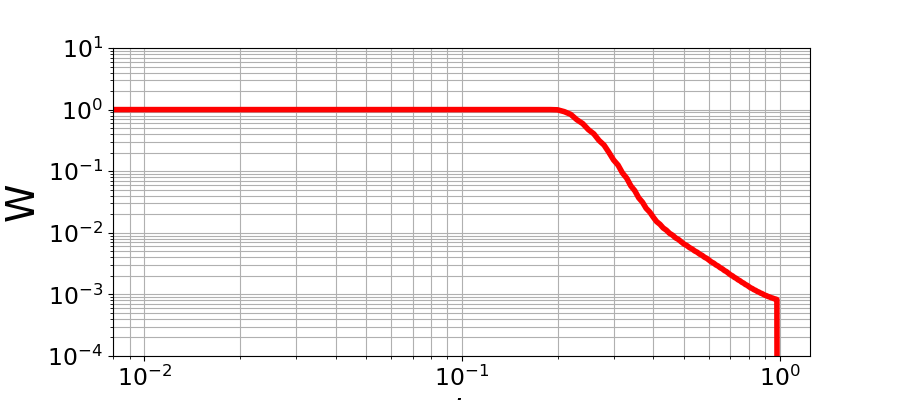

In [4]:
W = 1-(np.cumsum(pdf)*dbin)
W[W == 0] = 'nan'

plt.figure(figsize=(9, 4))
plt.loglog(cumbins, W[:], 'r', linewidth=4)
plt.xlabel("$i_t$", fontsize=24)
plt.ylabel('W', fontsize=28)
plt.ylim([10e-5, 10e0])
plt.grid(True, which='both')

# Increase tick size
plt.tick_params(axis='both', which='major', labelsize=17)
plt.tick_params(axis='both', which='minor', labelsize=17)

plt.savefig(figout[0])
plt.show()

## calculate L

In [ ]:
L0 = np.log(abs(W))
kernel_size = 11
L = detector.triangle_smoothing_1d(L0, kernel_size)

## Calculate Lp

In [ ]:
Lp0 = np.gradient(L, dbin)

## visualize the L"

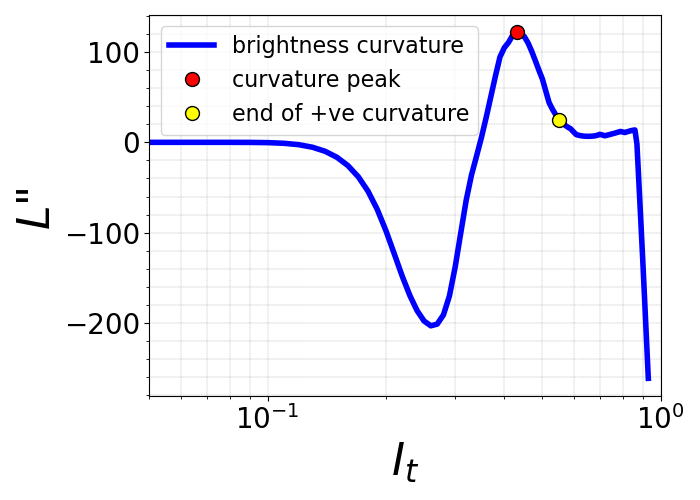

In [7]:
LPP0 = np.gradient(Lp0, dbin)[:-6]
#LPP0 = np.gradient(Lp0, dbin)[:]

LPP2 = detector.triangle_smoothing_1d(LPP0, kernel_size)
bins2 = cumbins[:-6]
#bins2 = cumbins[:]

Lmax = max(LPP2) #fetch the max value of the curvature
max_indx = np.where(LPP2 == Lmax) #use the max curvature value to get the the index of the corresponding    intensity
xmax = bins2[max_indx] # get the value of the intensity based on the index above
indpos=np.where((bins2> xmax) & (LPP2>0)); 
try:
    #indposmx = np.max(indpos)
    indposmx = np.max(indpos)
    iposmx=bins2[indposmx];
except ValueError:  #raised if `y` is empty.
    pass

yellow = Lmax * 0.2
closest_indx = np.argmin(np.abs(LPP2 - yellow))

plt.figure(figsize=(7,5))
plt.semilogx(bins2, LPP2, 'b',scalex = True, linewidth=4)
plt.semilogx(xmax,LPP2[max_indx],'o',markeredgecolor='black', markersize = 10, markerfacecolor='red')
plt.semilogx(bins2[closest_indx], yellow, 'o', markeredgecolor='black',markersize = 10, markerfacecolor='yellow');

plt.xlabel("$I_t$", fontsize=32, fontstyle='italic')  # Italicize the xlabel
plt.ylabel('L"', fontsize=32, fontstyle='italic')  # Italicize 
plt.legend(['brightness curvature','curvature peak','end of +ve curvature'], fontsize=16)

plt.minorticks_on()
plt.grid(which='both', color='gray', linestyle='--', linewidth=0.22)
plt.xlim([0.05,1])


# Increase tick size
plt.tick_params(axis='both', which='both', labelsize=20)
plt.tight_layout()
plt.savefig(figout[1])
plt.show()

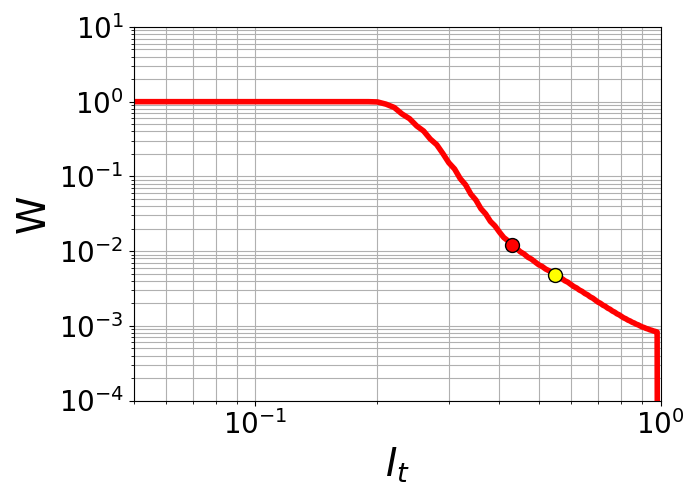

In [8]:
plt.figure(figsize=(7, 5))
plt.loglog(cumbins[:], W[:], 'r', linewidth=4)

plt.loglog(xmax,W[max_indx],'o',markeredgecolor='black',  markersize = 10, markerfacecolor='red')
plt.loglog(bins2[closest_indx], W[closest_indx], 'o', markeredgecolor='black', markersize = 10, markerfacecolor='yellow');

plt.xlabel("$I_t$", fontsize=28)
plt.ylabel('W', fontsize=28)
plt.ylim([10e-5, 10e0])
plt.grid(True, which='both')
plt.xlim([0.05,1])

# Increase tick size
plt.tick_params(axis='both', which='both', labelsize=20)
plt.tight_layout()

plt.savefig(figout[0])
plt.show()

# Save the computed intensity thresholds

In [9]:
#yellow=float(green)
yellow = float(bins2[closest_indx])
orange =xmax[0]
dummy =list([orange,yellow])
np.savetxt(fname_thresh, 
           dummy,
           delimiter =", ", 
           fmt ='% s')

loaded_thresh = np.genfromtxt(fname_thresh, delimiter=',')
orange = loaded_thresh[0]
yellow = loaded_thresh[1]

if not os.path.exists(datadir):
    os.makedirs(datadir)
datapth = datadir + fstr +'_' +str(yellow) +"_non_adaptive.npz"

In [11]:
#yellow
orange

0.43

In [12]:
float(yellow)

0.55